In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import importlib

import sklearn
#baseline linear regression
from sklearn import linear_model
#import sklearn.linear_model
#normalization
from sklearn import preprocessing
#train/test split
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
#metrics
from sklearn.metrics import mean_absolute_error

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [2]:
import platform
print(platform.python_version())

3.6.2


In [2]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\DeepLearning\\DNN.py'>

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [182]:
df1 = pd.read_csv(r'..\Zillow\properties_2016.csv')
print(df1.shape)
df2 = pd.read_csv(r'..\Zillow\train_2016_v2.csv')
print(df2.shape)


C:\Anaconda5\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(90275, 3)


In [24]:
#df2[df2.transactiondate >= '2016-10-15']
df2[df2.transactiondate < '2016-10-15'].shape
#max(df2.transactiondate)

(85670, 3)

In [6]:
df_train = df2.merge(df1, how='left', on='parcelid')

#revisit this fillna
df_train = df_train.fillna(0)

df_train['taxdelinquencyflag'] = df_train.taxdelinquencyflag.apply(lambda x: 1 if x == 'Y' else 0 )
df_train['fireplaceflag'] = df_train.hashottuborspa.astype(int)
df_train['hashottuborspa'] = df_train.hashottuborspa.astype(int)

#use all old data for training
#split the new data, 50% train, 50% dev
df_train_1 = df_train[df_train.transactiondate < '2016-10-15']
df_train_2 = df_train[df_train.transactiondate >= '2016-10-15']

train_index, dev_index = train_test_split(df_train_2.index, test_size=0.5, random_state=0)
df_train = pd.concat([df_train_1, df_train_2.loc[train_index]])
df_dev = df_train_2.loc[dev_index]

y_train = df_train.logerror.values
y_dev = df_dev.logerror.values

df_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
df_dev = df_dev.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

X_train = df_train.values
X_dev = df_dev.values

print(X_train.shape)
print(X_dev.shape)

(87972, 55)
(2303, 55)


In [7]:
#normalization - mean, var from train set, apply to dev set and test set
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)   
X_dev = scaler.transform(X_dev)

X_train_k = X_train
X_dev_k = X_dev
Y_train_k = y_train.reshape(y_train.shape[0], 1)
Y_dev_k = y_dev.reshape(y_dev.shape[0], 1)

X_train_my = X_train.T
X_dev_my = X_dev.T
Y_train_my = y_train.reshape(1, y_train.shape[0])
Y_dev_my = y_dev.reshape(1, y_dev.shape[0])



In [9]:
np.random.seed(0) # set a seed so that the results are consistent
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
print(mean_absolute_error(y_train, y_pred))
y_pred = regr.predict(X_dev)
print(mean_absolute_error(y_dev, y_pred))

0.0683074122879
0.0710661821951


In [7]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['mean_absolute_error'], logs['val_mean_absolute_error']) 

In [10]:
np.random.seed(0)
model = Sequential()

initializer = keras.initializers.he_normal()

regularizer = None

model.add(Dense(100, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(20, kernel_initializer=initializer, activation='relu'))
#model.add(Dense(20, kernel_initializer=initializer, activation='relu'))
model.add(Dense(1, kernel_initializer=initializer))

#optimizer = optimizers.SGD(lr=0.05, momentum=0.9)
#optimizer = optimizers.RMSprop(lr=0.01)
optimizer = optimizers.Adam(lr=0.005)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

results_k = {'loss': [], 'eval0': []}

In [11]:
initial_epoch = 0
epochs = 100
verbose = 0
verbose2 = 10
#batch_size = int(X_train_k.shape[0])
batch_size = 512

results_k_tmp = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)

Y_predict_k = model.predict(X_train_k)
print(mean_absolute_error(Y_train_k, Y_predict_k))
Y_predict_k = model.predict(X_dev_k)
print(mean_absolute_error(Y_dev_k, Y_predict_k))

results_k['loss'] += results_k_tmp.history['loss']
results_k['eval0'] += results_k_tmp.history['mean_absolute_error']

0 0.0367049118399 0.0880141962608 0.072243984897
10 0.0257207859538 0.0690192610553 0.0725026416244
20 0.0262263047524 0.0691210498 0.0715653259684
30 0.0256708692797 0.0689763535848 0.0718260483733
40 0.0256870149762 0.0689584433352 0.071545965824
50 0.0255188171343 0.0689776337597 0.0709854542653
60 0.0254559158795 0.0688510233552 0.0728517379927
70 0.0256183924012 0.0687386739909 0.0713623790762
80 0.0255158078948 0.0687632279239 0.0708649374425
90 0.0253848011869 0.0685865413818 0.0721621552447
0.0686328811312
0.0708894346471


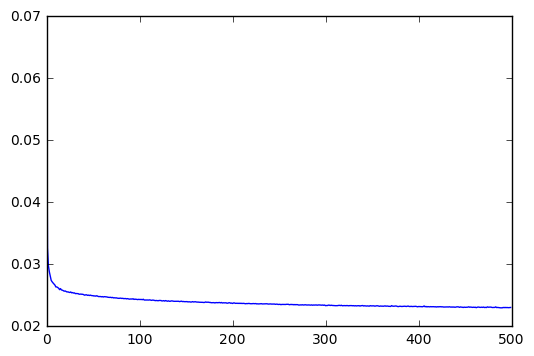

In [27]:
#plt.plot(results_k['loss'])
#plt.show()
df_loss_k = pd.DataFrame(results_k['loss'][500:])
df_loss_k[0].ewm(span=50).mean().plot(style='k')

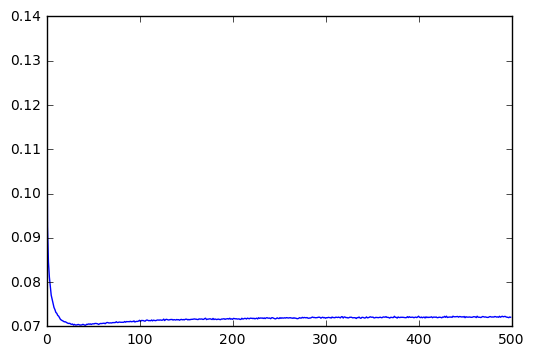

In [28]:
#plt.plot(results_k['eval0'])
#plt.show()
df_eval0_k = pd.DataFrame(results_k['eval0'][100:])
df_eval0_k[0].ewm(span=50).mean().plot(style='k')

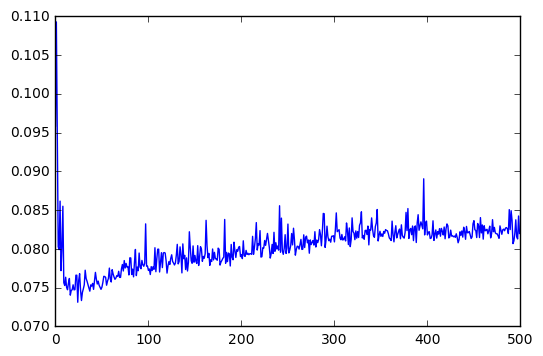

In [29]:
plt.plot(results_k.history['val_mean_absolute_error'])
plt.show()

In [128]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\DeepLearning\\DNN.py'>

In [129]:
#random seed for parameters init and mini batch shuffle
np.random.seed(0)
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(100, DNN.relu)
dnn.add_layer(20, DNN.relu)
#dnn.add_layer(20, DNN.relu)
dnn.add_layer(1, DNN.identity)
dnn.costfunction = DNN.mean_squared_error
dnn.init = 'He'
dnn.optimizer = 'Adam'
dnn.compile()

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_my = {'loss': [], 'eval0': [], 'eval1': []}

In [229]:
learning_rate = 0.001
epochs = 71400
batch_size = 512
gradient_check=False
verbose = 1000

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_tmp = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='mae', learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, gradient_check=gradient_check, verbose=verbose)
Y_predict_my = dnn.predict(X_train_my)
print(mean_absolute_error(np.reshape(Y_train_my, Y_train_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))
Y_predict_my = dnn.predict(X_dev_my)
print(mean_absolute_error(np.reshape(Y_dev_my, Y_dev_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))

results_my['loss'] += results_tmp['loss']
results_my['eval0'] += results_tmp['eval0']
results_my['eval1'] += results_tmp['eval1']

print(dnn.epochs, dnn.minibatches)

2017-10-04 19:33:18.711741 Cost after iteration 0 ['0.023959', '0.064889', '0.075724']
2017-10-04 19:49:04.299249 Cost after iteration 1000 ['0.023958', '0.064828', '0.075738']
2017-10-04 20:04:54.983866 Cost after iteration 2000 ['0.023958', '0.064828', '0.075658']
2017-10-04 20:20:35.028146 Cost after iteration 3000 ['0.023958', '0.064904', '0.075736']
2017-10-04 20:36:16.312977 Cost after iteration 4000 ['0.023959', '0.065153', '0.075793']
2017-10-04 20:51:49.556748 Cost after iteration 5000 ['0.023957', '0.065573', '0.076088']
2017-10-04 21:07:22.305597 Cost after iteration 6000 ['0.023957', '0.064601', '0.075781']
2017-10-04 21:22:57.724927 Cost after iteration 7000 ['0.023957', '0.065368', '0.075947']
2017-10-04 21:38:31.356245 Cost after iteration 8000 ['0.023959', '0.064765', '0.075702']
2017-10-04 21:54:04.140171 Cost after iteration 9000 ['0.023962', '0.064940', '0.075741']
2017-10-04 22:09:42.044962 Cost after iteration 10000 ['0.023961', '0.065383', '0.076027']
2017-10-04 2

In [239]:
#dnn = DNN.DNN.load('file1.pickle')
dnn.save('file1.pickle')

#360K lr=0.005
#90K lr=0.001

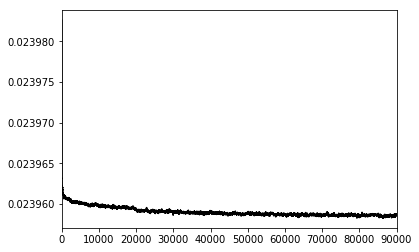

In [237]:
#plt.plot(results_my['loss'][100:])
#plt.show()
df_loss = pd.DataFrame(results_my['loss'][-90000:])
df_loss[df_loss[0] > 0.5] = df_loss[0].mean()
#df_loss[0].plot()
df_loss[0].ewm(span=200).mean().plot(style='k')

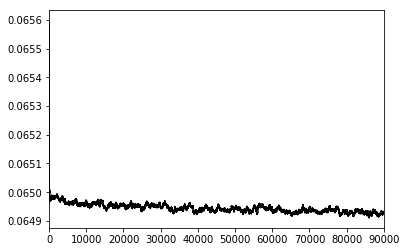

In [238]:
#plt.plot(results_my['eval0'][100:])
#plt.show()
df_eval0 = pd.DataFrame(results_my['eval0'][-90000:])
df_eval0[0].ewm(span=1000).mean().plot(style='k')

In [113]:
df_eval0[0].describe()

count    20.000000
mean      0.068786
std       0.000418
min       0.068378
25%       0.068556
50%       0.068653
75%       0.068921
max       0.070219
Name: 0, dtype: float64

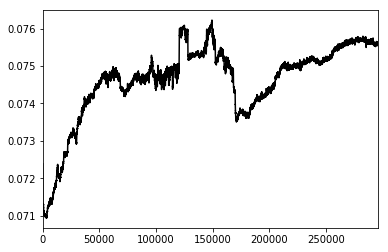

In [190]:
df_eval1 = pd.DataFrame(results_my['eval1'][100:])
df_eval1[0].ewm(span=200).mean().plot(style='k')

In [94]:
len(results_my['eval1'])

5000